#### Imports

In [ ]:
import yfinance as yf  # Download historical financial data from Yahoo Finance
import pandas as pd     # Data manipulation and analysis (DataFrames, time series)
import numpy as np      # Numerical operations and array handling
import matplotlib.pyplot as plt  # Basic plotting and visualizations
import seaborn as sns   # Statistical data visualization (enhanced plots)
from scipy.stats import kurtosis  # Compute kurtosis to detect fat tails
from statsmodels.graphics.tsaplots import plot_acf  # Plot autocorrelation functions
from arch.__future__ import reindexing  # Compatibility fix for arch with newer pandas
from arch import arch_model  # Estimate GARCH and EGARCH models
from statsmodels.stats.diagnostic import acorr_ljungbox  # Perform Ljung-Box test for autocorrelation

#### Downloading Historical Financial Data

In [79]:
assets = {
    'Equity_Index': "^GSPC", # S&P 500       
    'Stock': "AAPL", # Apple              
    'Currency_Pair': "GBPUSD=X", # GBPUSD   
    'Commodity': "ZC=F", # Corn futures       
    'Crypto': "ETH-USD"  # Ethereum          
}

start_date = "2020-05-01"
end_date = "2025-05-01"

data = yf.download(list(assets.values()), start=start_date, end=end_date)["Close"]

[*********************100%***********************]  5 of 5 completed


Renaming the DataFrame columns from technical ticker symbols to more readable asset names and saving the cleaned DataFrame to a CSV file

In [80]:
data = data.rename(columns={'^GSPC':'S&P 500',
                     'AAPL':'Apple',
                     'GBPUSD=X':'GBPUSD',
                     'ZC=F':'Corn futures',
                     "ETH-USD": 'Ethereum'})

data = data.round({col: 2 for col in data.columns if col != 'GBPUSD'})

data.dropna(inplace=True)

data.to_csv('data.csv')


In [81]:
data.head()

Ticker,Apple,Ethereum,GBPUSD,Corn futures,S&P 500
Date,,,,,
2020-05-01,70.06,214.22,1.258147,311.50,2830.71
2020-05-04,71.05,208.17,1.245423,310.75,2842.74
2020-05-05,72.12,206.77,1.244555,313.00,2868.44
2020-05-06,72.86,204.06,1.244420,311.75,2848.42
2020-05-07,73.61,212.29,1.232559,316.00,2881.19


In [82]:
data.tail()

Ticker,Apple,Ethereum,GBPUSD,Corn futures,S&P 500
Date,,,,,
2025-04-24,208.10,1769.83,1.326453,477.25,5484.77
2025-04-25,209.01,1786.63,1.332623,478.75,5525.21
2025-04-28,209.86,1798.85,1.329010,475.50,5528.75
2025-04-29,210.93,1799.18,1.343616,460.50,5560.83
2025-04-30,212.22,1793.78,1.341079,467.25,5569.06


Verify that the DataFrame index is correctly parsed as datetime values

In [83]:
data.index

DatetimeIndex(['2020-05-01', '2020-05-04', '2020-05-05', '2020-05-06',
               '2020-05-07', '2020-05-08', '2020-05-11', '2020-05-12',
               '2020-05-13', '2020-05-14',
               ...
               '2025-04-15', '2025-04-16', '2025-04-17', '2025-04-22',
               '2025-04-23', '2025-04-24', '2025-04-25', '2025-04-28',
               '2025-04-29', '2025-04-30'],
              dtype='datetime64[ns]', name='Date', length=1255, freq=None)

The in-sample period is starting on 2020-05-01

In [101]:
in_sample = data.iloc[:-365]


The out-of-sample period is lasting for 365 days and is starting on 2024-05-01

In [85]:
out_of_sample = data.iloc[-365:]

In [86]:
log_returns = np.log(data / data.shift(1)).dropna()
log_returns.head()


Ticker,Apple,Ethereum,GBPUSD,Corn futures,S&P 500
Date,,,,,
2020-05-04,0.014032,-0.028648,-0.010164,-0.002411,0.004241
2020-05-05,0.014948,-0.006748,-0.000697,0.007214,0.009000
2020-05-06,0.010208,-0.013193,-0.000108,-0.004002,-0.007004
2020-05-07,0.010241,0.039539,-0.009577,0.013541,0.011439
2020-05-08,0.023628,0.003292,0.004076,0.009449,0.016731


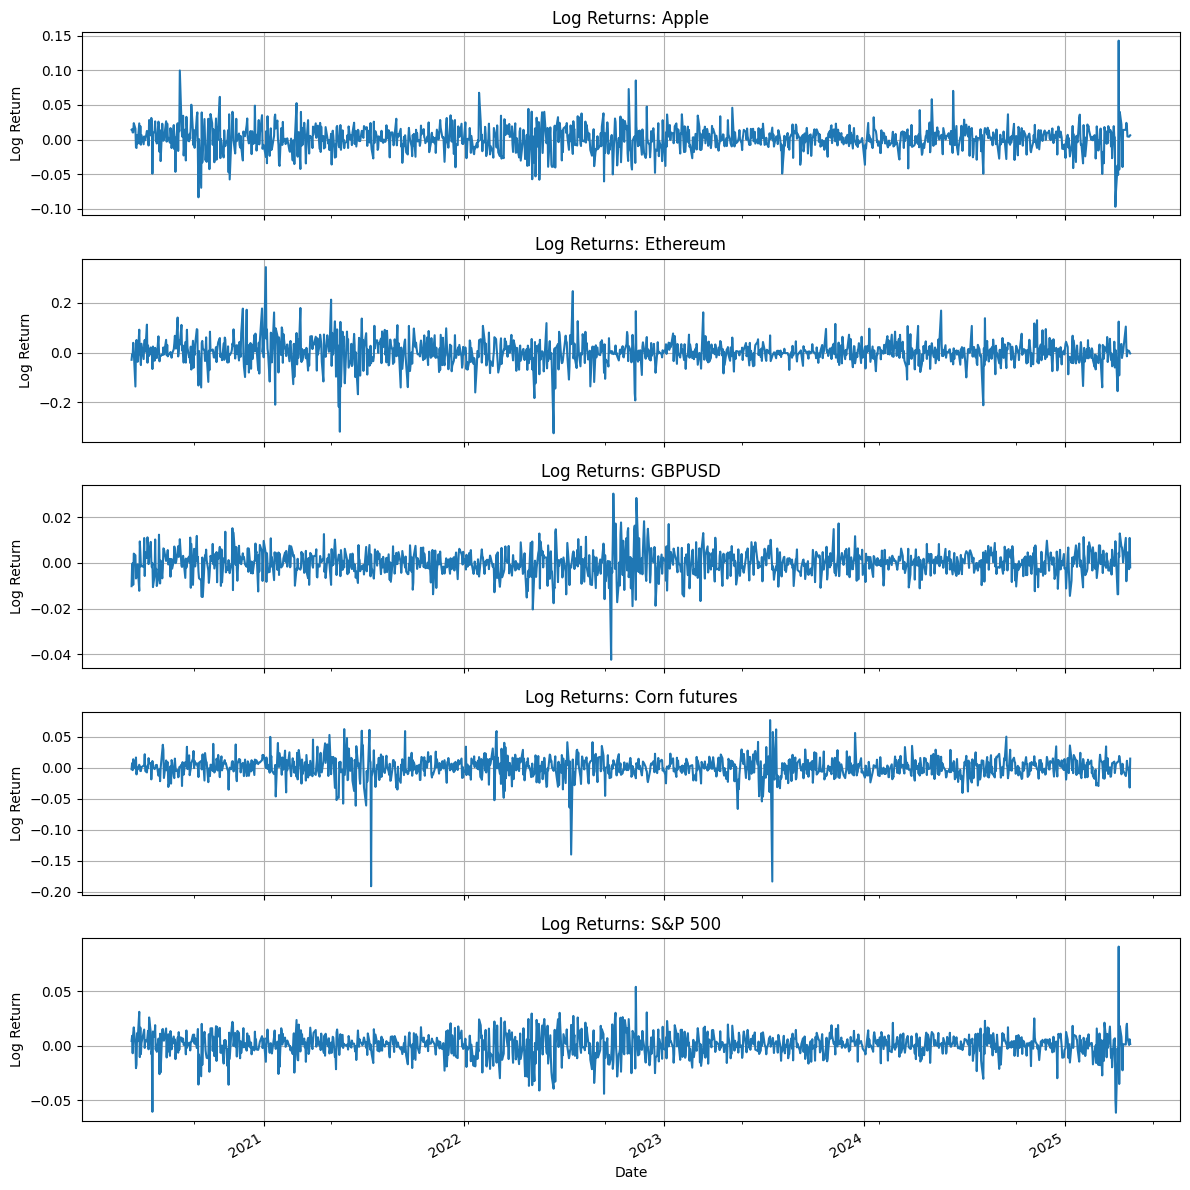

In [87]:
# Ustaw figure i osie (5 wierszy, 1 kolumna)
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(12, 12), sharex=True)

# Iteruj po aktywach i przypisanych osiach
for i, asset in enumerate(log_returns.columns):
    ax = axes[i]
    log_returns[asset].plot(ax=ax)
    ax.set_title(f"Log Returns: {asset}")
    ax.set_ylabel("Log Return")
    ax.grid(True)

# Etykieta osi X tylko na ostatnim wykresie
axes[-1].set_xlabel("Date")

plt.tight_layout()
plt.show()


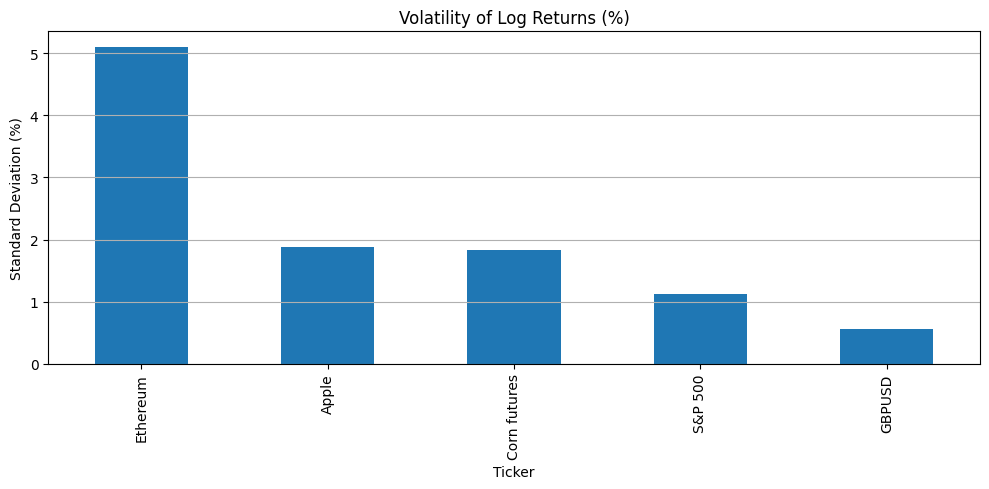

In [88]:
volatility = log_returns.std() * 100  # w %
volatility.sort_values(ascending=False).plot(kind='bar', figsize=(10, 5), title='Volatility of Log Returns (%)')
plt.ylabel("Standard Deviation (%)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


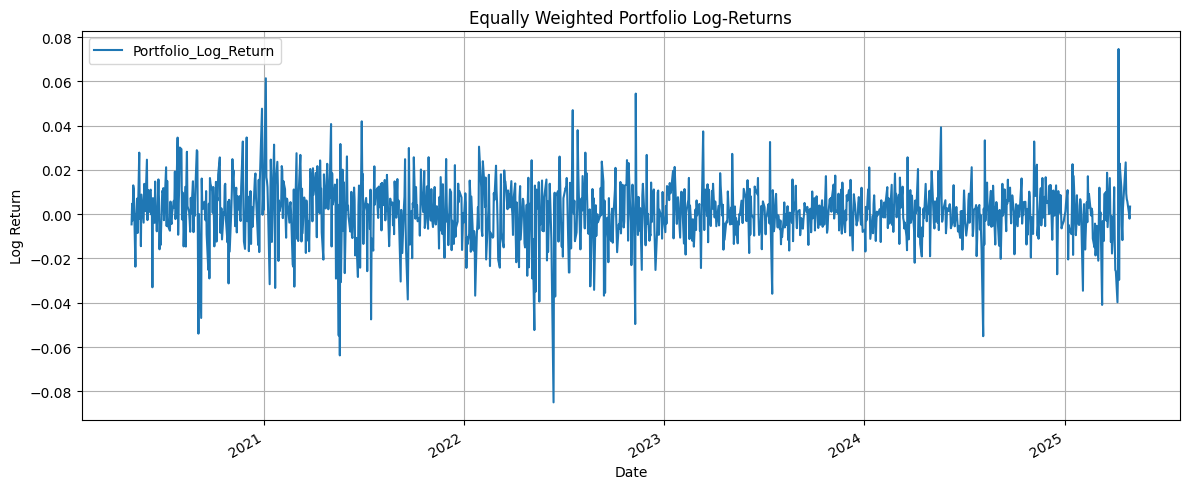

In [89]:
# Compute portfolio log-returns (equal weights = 0.2 each)
equal_weights = np.repeat(0.2, 5)
portfolio_returns = log_returns @ equal_weights  # matrix multiplication

# Convert to DataFrame for convenience
portfolio_returns = portfolio_returns.to_frame(name='Portfolio_Log_Return')

# Plot portfolio log-returns
portfolio_returns.plot(figsize=(12, 5), title='Equally Weighted Portfolio Log-Returns')
plt.ylabel('Log Return')
plt.grid(True)
plt.tight_layout()
plt.show()


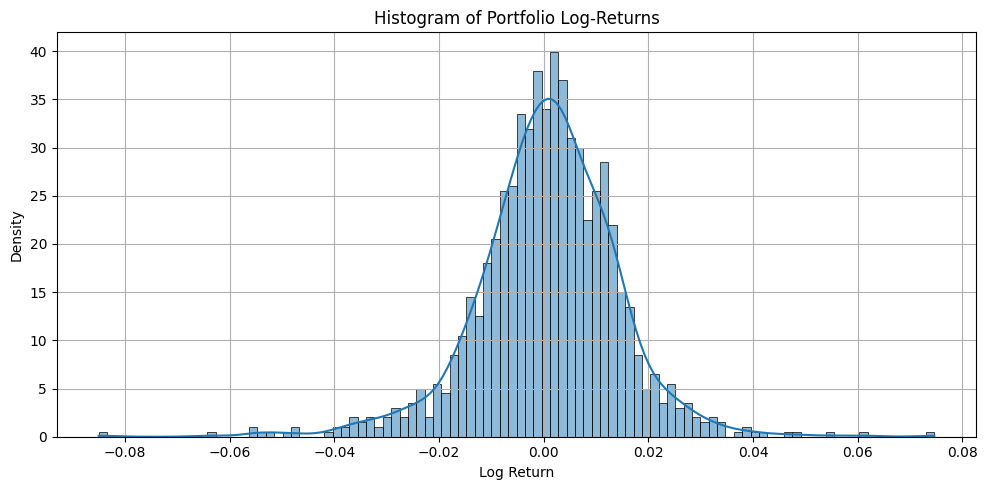

Sample excess kurtosis: 3.71


In [90]:


# Plot histogram with KDE
plt.figure(figsize=(10, 5))
sns.histplot(portfolio_returns['Portfolio_Log_Return'], bins=100, kde=True, stat='density')
plt.title('Histogram of Portfolio Log-Returns')
plt.xlabel('Log Return')
plt.ylabel('Density')
plt.grid(True)
plt.tight_layout()
plt.show()

# Compute sample kurtosis
kurt = kurtosis(portfolio_returns['Portfolio_Log_Return'], fisher=True)
print(f"Sample excess kurtosis: {kurt:.2f}")


The sample excess kurtosis value of 3.71 is significantly higher than zero (which is the excess kurtosis of a normal distribution), indicating a leptokurtic distribution

<Figure size 1000x400 with 0 Axes>

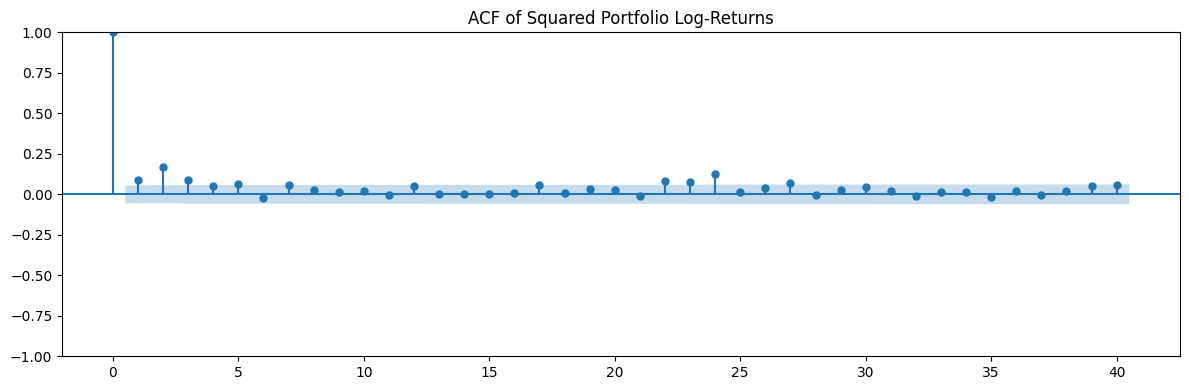

In [91]:
from statsmodels.graphics.tsaplots import plot_acf

# Plot ACF of squared returns
squared_returns = portfolio_returns['Portfolio_Log_Return'] ** 2

plt.figure(figsize=(10, 4))
plot_acf(squared_returns, lags=40, title="ACF of Squared Portfolio Log-Returns")
plt.tight_layout()
plt.show()


The ACF of squared returns shows significant autocorrelation at the first few lags.
This indicates time-varying volatility, supporting the use of GARCH-family models

#### Summary of stylized Facts

1.Volatility clustering – from time series plot

2.Leptokurtosis – from histogram + kurtosis = 3.71

3.ARCH effects – from ACF of squared returns

In [92]:


# Use only the in-sample data
# Align portfolio returns with in-sample period (based on dates)
portfolio_in_sample = portfolio_returns.loc[portfolio_returns.index < "2024-05-01"]


# Fit EGARCH(1,1)
# Refit EGARCH(1,1) with asymmetry term
model_egarch_asym = arch_model(portfolio_in_sample * 100, vol='EGARCH', p=1, o=1, q=1, mean='Constant', dist='normal')
result_egarch_asym = model_egarch_asym.fit(disp='off')

print(result_egarch_asym.summary())



                      Constant Mean - EGARCH Model Results                      
Dep. Variable:     Portfolio_Log_Return   R-squared:                       0.000
Mean Model:               Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       EGARCH   Log-Likelihood:               -1699.64
Distribution:                    Normal   AIC:                           3409.27
Method:              Maximum Likelihood   BIC:                           3433.83
                                          No. Observations:                 1005
Date:                  Thu, May 29 2025   Df Residuals:                     1004
Time:                          20:56:11   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0825  3.828e-02      2.154  3

In [93]:
# Get standardized residuals and conditional volatility
std_resid = result_egarch_asym.std_resid
cond_vol = result_egarch_asym.conditional_volatility


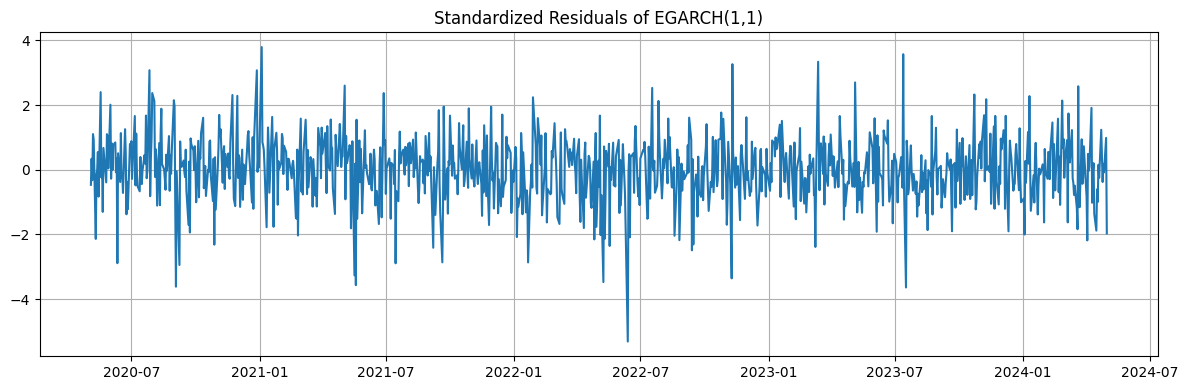

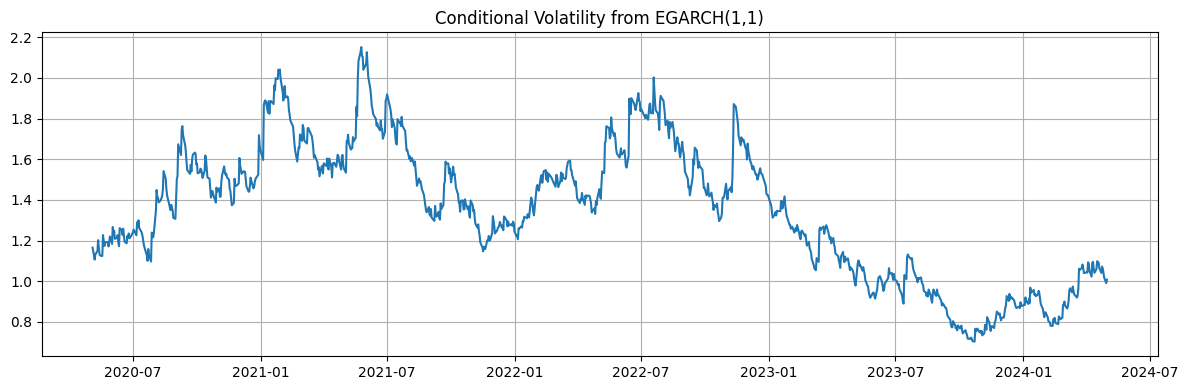

In [94]:
# Plot standardized residuals
plt.figure(figsize=(12, 4))
plt.plot(std_resid)
plt.title("Standardized Residuals of EGARCH(1,1)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot conditional volatility
plt.figure(figsize=(12, 4))
plt.plot(cond_vol)
plt.title("Conditional Volatility from EGARCH(1,1)")
plt.grid(True)
plt.tight_layout()
plt.show()


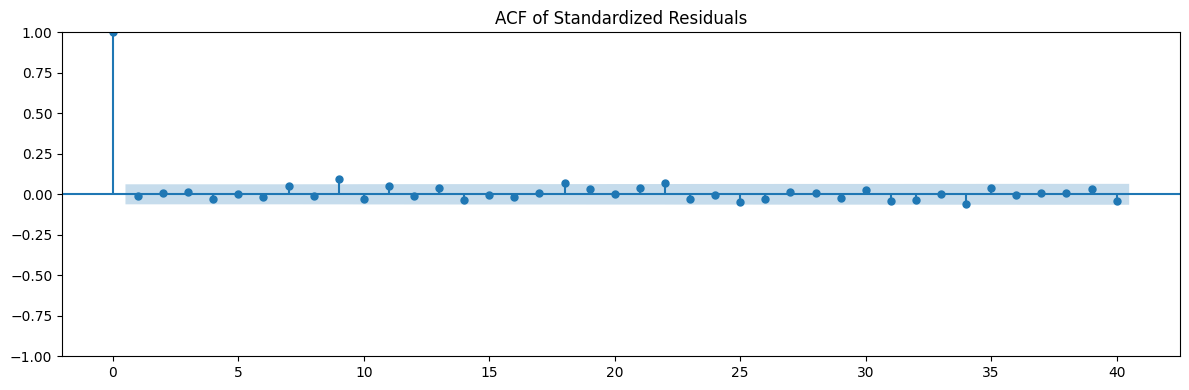

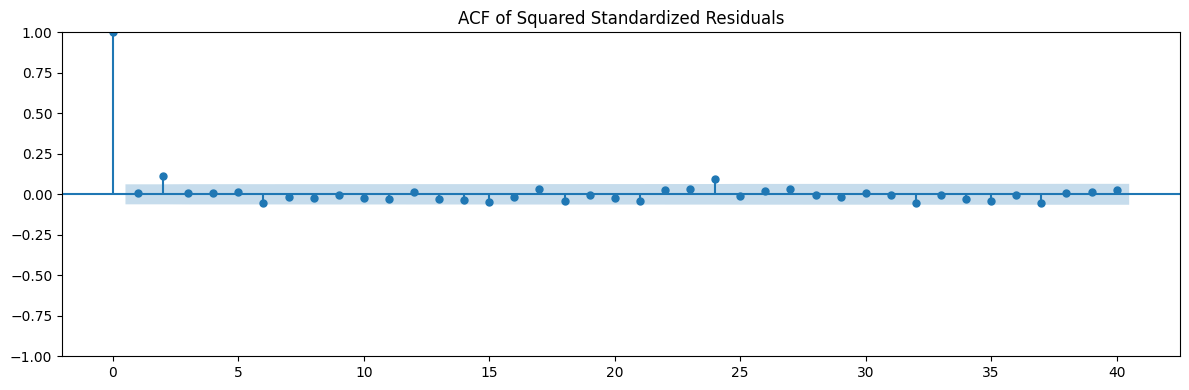

In [95]:


# ACF of standardized residuals
plot_acf(std_resid, lags=40)
plt.title("ACF of Standardized Residuals")
plt.tight_layout()
plt.show()

# ACF of squared standardized residuals
plot_acf(std_resid**2, lags=40)
plt.title("ACF of Squared Standardized Residuals")
plt.tight_layout()
plt.show()


Interpretation
ACF of standardized residuals:
All autocorrelations fall within the 95% confidence band (light blue area)

⇒ No significant autocorrelation remains
✅ → White noise residuals

ACF of squared standardized residuals:
Same story — no strong autocorrelations

⇒ No remaining ARCH effects
✅ → EGARCH captured volatility dynamics properly

In [96]:


# ARCH LM test is built into the result object
arch_lm = result_egarch_asym.arch_lm_test(lags=10)

print("ARCH LM test (10 lags):")
print(arch_lm)


ARCH LM test (10 lags):
ARCH-LM Test
H0: Residuals are homoskedastic.
ARCH-LM Test
H1: Residuals are conditionally heteroskedastic.
Statistic: 39.3909
P-value: 0.0000
Distributed: <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001AC8ED5C2D0>


Residual diagnostics confirm no significant autocorrelation in standardized and squared residuals. However, the ARCH LM test suggests some residual heteroskedasticity may remain, indicating potential room for model improvement (e.g. heavier-tailed distributions or higher-order terms).

In [97]:


# Ljung-Box on residuals and squared residuals
ljung_resid = acorr_ljungbox(std_resid, lags=[10, 20], return_df=True)
ljung_sq = acorr_ljungbox(std_resid**2, lags=[10, 20], return_df=True)

print("Ljung-Box (standardized residuals):")
print(ljung_resid, "\n")

print("Ljung-Box (squared standardized residuals):")
print(ljung_sq, "\n")


Ljung-Box (standardized residuals):
      lb_stat  lb_pvalue
10  14.363376   0.157053
20  26.078538   0.163234 

Ljung-Box (squared standardized residuals):
      lb_stat  lb_pvalue
10  16.815607   0.078545
20  25.256616   0.191789 



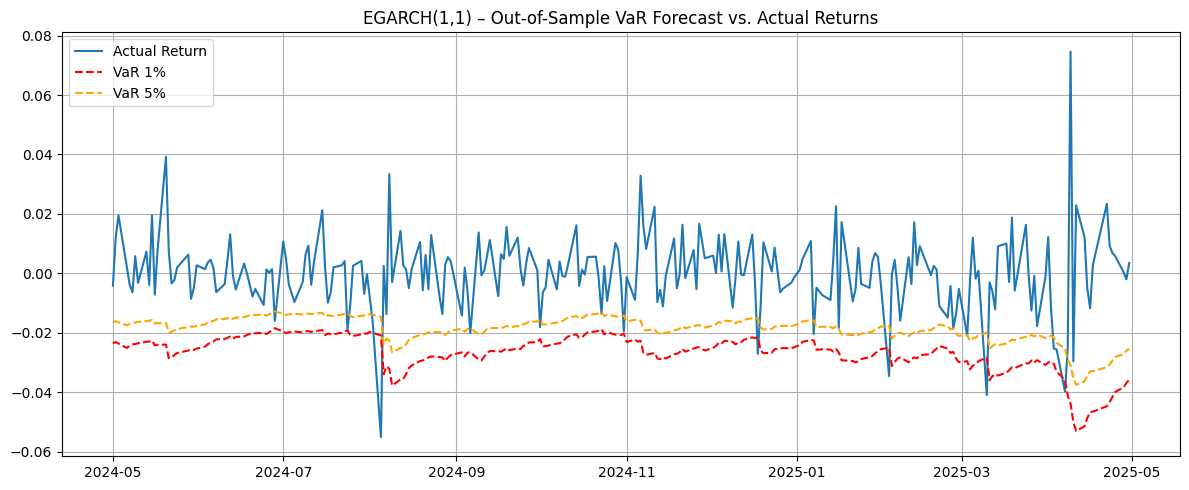

In [98]:



# Step 1: Setup
returns = portfolio_returns['Portfolio_Log_Return'] * 100  # scale
rolling_window = 1005
returns_oos = returns.loc["2024-05-01":]
n_oos = len(returns_oos)
forecast_dates = returns_oos.index

var_1 = []
var_5 = []

# Step 2: Rolling forecast
for i in range(n_oos):
    train_data = returns.iloc[i:i + rolling_window]
    model = arch_model(train_data, vol='EGARCH', p=1, o=1, q=1, mean='Constant', dist='normal')
    res = model.fit(disp="off")
    
    forecast = res.forecast(horizon=1)
    sigma = np.sqrt(forecast.variance.values[-1, 0])
    mu = forecast.mean.values[-1, 0]
    
    var_1.append(mu - 2.326 * sigma)
    var_5.append(mu - 1.645 * sigma)

# Step 3: Assemble results
var_df = pd.DataFrame({
    'VaR_1%': np.array(var_1) / 100,
    'VaR_5%': np.array(var_5) / 100,
    'Actual': returns_oos.values / 100
}, index=forecast_dates)

# Step 4: Plot
plt.figure(figsize=(12, 5))
plt.plot(var_df.index, var_df['Actual'], label='Actual Return')
plt.plot(var_df.index, var_df['VaR_1%'], label='VaR 1%', linestyle='--', color='red')
plt.plot(var_df.index, var_df['VaR_5%'], label='VaR 5%', linestyle='--', color='orange')
plt.fill_between(var_df.index, var_df['VaR_1%'], var_df['Actual'],
                 where=var_df['Actual'] < var_df['VaR_1%'], color='red', alpha=0.2)
plt.title('EGARCH(1,1) – Out-of-Sample VaR Forecast vs. Actual Returns')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Blue line (Actual Return): This line shows the actual realized returns of the asset over time. These values fluctuate above and below zero.

Red dashed line (VaR 1%): This is the 1% Value at Risk level. It indicates that there's only a 1% probability that returns will fall below this level on a given day. It's a very conservative risk estimate.

Orange dashed line (VaR 5%): This line represents the 5% Value at Risk level. There's a 5% probability that returns will fall below this level on a given day

In [99]:
# Count violations
violations_1 = (var_df['Actual'] < var_df['VaR_1%']).sum()
violations_5 = (var_df['Actual'] < var_df['VaR_5%']).sum()

# Total forecasts
total_obs = len(var_df)

# Print results
print(f"VaR 1% violations: {violations_1} / {total_obs} ({violations_1 / total_obs * 100:.2f}%)")
print(f"VaR 5% violations: {violations_5} / {total_obs} ({violations_5 / total_obs * 100:.2f}%)")


VaR 1% violations: 5 / 249 (2.01%)
VaR 5% violations: 16 / 249 (6.43%)
